In [1]:
from os import listdir
from os.path import isfile, join
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
from pyspark.sql.functions import sum as spark_sum, col, collect_list
spark = SparkSession.builder.appName("QueryScript").getOrCreate()

def query_table(file_name):
    try:
        df = spark.read.parquet(file_name)
        df.createOrReplaceTempView("test_df")
        result = spark.sql("""
            SELECT s, t, c_list, size(c_list) as num_pages,
                aggregate(c_list, 0, (x, y) -> x + y) as details_sum
            FROM test_df ORDER BY details_sum DESC
        """)
        return result
    except AnalysisException as e:
        # Catch and ignore errors
        print(f"Error processing {file_name}: {e}")
        return None
    
query_table("spark-warehouse/output_table_0003").show(10)

your 131072x1 screen size is bogus. expect trouble
24/01/27 16:57:44 WARN Utils: Your hostname, GS22411 resolves to a loopback address: 127.0.1.1; using 172.19.21.106 instead (on interface eth0)
24/01/27 16:57:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/27 16:57:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Error processing spark-warehouse/output_table_0003: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.


AttributeError: 'NoneType' object has no attribute 'show'

In [11]:
def query_all_tables(directory):
    files = [f for f in listdir(directory)]
    
    all_results = []
    print(join(directory, files[0]))
    for file_name in files:
        
        result_df = query_table(join(directory, file_name))
        if result_df:
            all_results.append(result_df)

    print(len(all_results))

    # Merge all DataFrames and group by s and t
    merged_df = all_results[0] if all_results else None
    for df in all_results[1:]:
        merged_df = merged_df.union(df)

    grouped_df = merged_df.groupBy("s", "t").agg(
        spark_sum("num_pages").alias("total_num_pages"),
        spark_sum("details_sum").alias("total_details_sum"),
        collect_list("c_list").alias("link_dist"),
    )
    grouped_df = grouped_df.withColumn("ratio", col("total_details_sum") / col("total_num_pages"))
    return grouped_df

df_link_counts = query_all_tables("spark-warehouse/")
ordered_df = df_link_counts.orderBy("ratio", ascending=False)
ordered_df.show(5, truncate=False)

spark-warehouse/output_table_0001
Error processing spark-warehouse/output_table_0001: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
Error processing spark-warehouse/old_outputs: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually.
1
+---+---+---------------+-----------------+---------+-----+
|s  |t  |total_num_pages|total_details_sum|link_dist|ratio|
+---+---+---------------+-----------------+---------+-----+
+---+---+---------------+-----------------+---------+-----+



In [7]:
df_link_dists = ordered_df.toPandas()
df_link_dists.describe()

,total_num_pages,total_details_sum,ratio
count,5048.000000,5048.000000,5048.000000
mean,19.007528,63.966125,1.195848
std,149.139678,1854.702262,1.396932
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1765.000000,123550.000000,70.000000


In [8]:
import pandas as pd
import numpy as np

def reverse_url(url):
    components = url.split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

def is_substring(row, col_a, col_b):
    return row[col_a] not in row[col_b]

df_link_dists['t'] = df_link_dists['t'].apply(reverse_url)
df_link_dists['s'] = df_link_dists['s'].apply(reverse_url)

labels = pd.read_csv('../../submitted/link_scheme_removal/data/attributes.csv')[['url','label']]
df_link_dists_labelled = df_link_dists.merge(right=labels, left_on='t', right_on='url', how='inner')
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['t'] in row['s'], axis=1)]
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['s'] in row['t'], axis=1)]
df_link_dists_labelled['link_dist'] = df_link_dists_labelled['link_dist'].apply(np.concatenate)
df_link_dists_labelled.describe()

,total_num_pages,total_details_sum,ratio,label
count,136.000000,136.000000,136.000000,136.000000
mean,2.867647,3.058824,1.066375,4.691176
std,5.076903,5.313525,0.248721,0.704638
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,5.000000
50%,1.000000,1.000000,1.000000,5.000000
75%,3.000000,3.000000,1.000000,5.000000
max,53.000000,54.000000,3.000000,5.000000


/home/peter/miniconda3/envs/lsr/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)


<Axes: xlabel='label', ylabel='mean'>

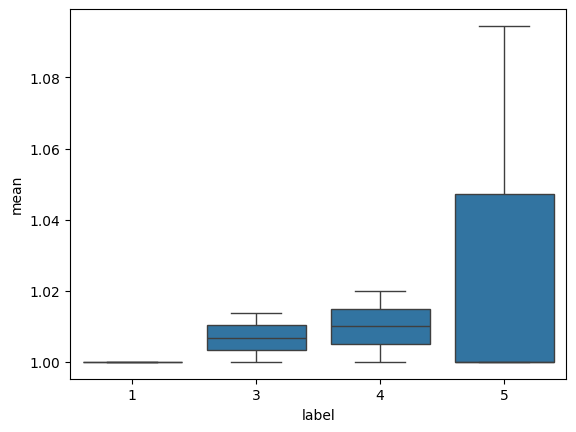

In [9]:
from scipy.stats import skew
import seaborn as sns
df_link_source_dists_labelled = df_link_dists_labelled.groupby(['s', 'label'])['link_dist'].agg(list).reset_index()
df_link_source_dists_labelled['link_dist'] = df_link_source_dists_labelled['link_dist'].apply(np.concatenate)

# # Reset the index to make 's' and 'label' regular columns
# df_link_source_dists_labelled = df_link_source_dists_labelled.reset_index()
df_link_source_dists_labelled.head()


# df_label_dists = df_label_dists.reset_index(drop=True)
# df_label_dists = pd.DataFrame(df_label_dists)
# # df_label_dists_exploded = df_label_dists.explode('skew')
# # df_label_dists['skew'] = df_label_dists['skew'].apply(np.concatenate)
# # df_label_dists['skew_filtered'] = df_label_dists['skew']#.apply(lambda x: [value for value in x if value > 10 and value != 29])
# sns.boxplot(x='label', y='skew', data=df_label_dists.explode('skew'),log_scale=True)

df_link_source_dists_labelled['mean'] = df_link_source_dists_labelled['link_dist'].apply(np.mean)
df_link_source_dists_labelled['skew'] = df_link_source_dists_labelled['link_dist'].apply(skew)
# df_link_source_dists_labelled = df_link_dists_labelled.groupby(['s', 'label'])['skew'].agg(list).reset_index()
sns.boxplot(x='label', y='mean', data=df_link_source_dists_labelled.explode('mean'), showfliers=False)

<Axes: xlabel='label', ylabel='link_dist_filtered'>

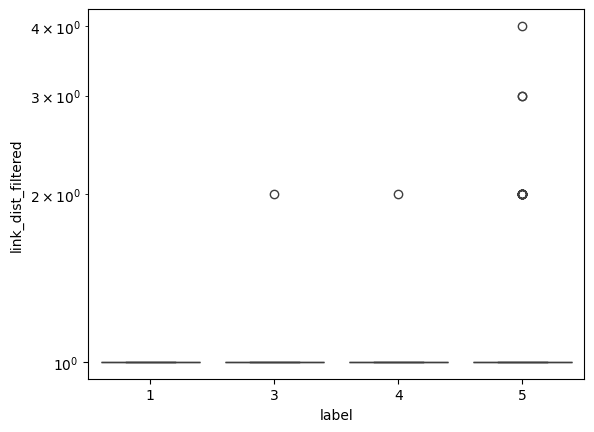

In [10]:
import seaborn as sns
df_label_dists = df_link_dists_labelled.groupby('label')['link_dist'].agg(list).reset_index()
df_label_dists['link_dist'] = df_label_dists['link_dist'].apply(np.concatenate)
df_label_dists['link_dist_filtered'] = df_label_dists['link_dist']#.apply(lambda x: [value for value in x if value > 10 and value != 29])
sns.boxplot(x='label', y='link_dist_filtered', data=df_label_dists.explode('link_dist_filtered'),log_scale=True)

In [ ]:
df_label_source_dists = df_link_dists_labelled.groupby('')['link_dist'].agg(list).reset_index()
